## Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data, investigate distributions of different like thresholds

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

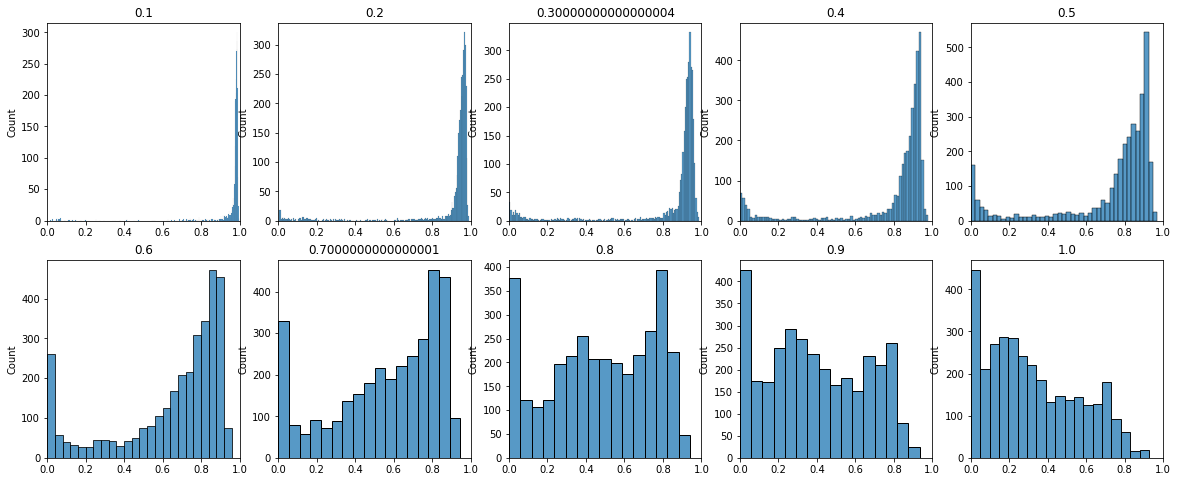

In [3]:
f, axes = plt.subplots(2,5)
f.set_size_inches(20,8)

cutoffs = np.linspace(0.1,1,10)
for i in range(len(cutoffs)):
    c = cutoffs[i]
    ax = (int(i > 4),i % 5)
    temp_df = kuairec_df.copy()
    temp_df['liked'] = kuairec_df['watch_ratio'] > c
    temp_df['liked'] = temp_df['liked'].astype(int)
    video_df = temp_df.groupby(['video_id']).mean()['liked']
    plt.sca(axes[ax[0], ax[1]])
    plt.xlim(0,1)
    sns.histplot(video_df.values).set_title(c)

In [4]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [5]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [6]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [7]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [8]:
print(prior_a, prior_b)

1.419151045702662 0.5893613591858907


In [9]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

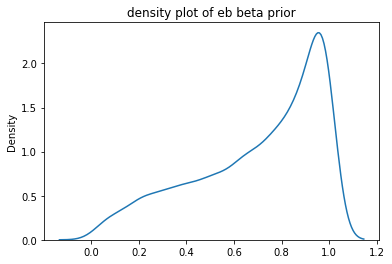

In [10]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

In [11]:
video_df

video_id
103      0.857447
109      0.920624
120      0.928420
122      0.889283
128      0.836286
           ...   
10506    0.937911
10519    0.950925
10552    0.143262
10589    0.906562
10595    0.945266
Name: liked, Length: 3327, dtype: float64

## Step 2: Merge the datasets and select from test set different products

In [12]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [13]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,1,0.946137
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,1,0.946137
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.946137
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.946137
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,1,0.946137


Text(0.5, 1.0, 'histogram of like ratios')

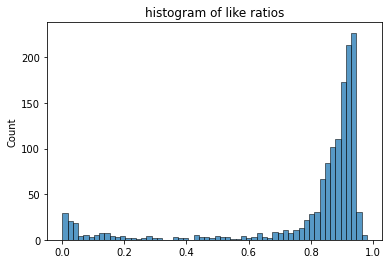

In [14]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [15]:
num_samples = 100

In [16]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [17]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [18]:
video_df[sampled_videos].sort_values()

video_id
9136    0.002835
8696    0.006383
883     0.008505
7585    0.015603
7566    0.024805
          ...   
858     0.939759
2311    0.942512
6882    0.942594
2687    0.945429
7076    0.950390
Name: liked, Length: 100, dtype: float64

In [19]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[0, num_samples//4, 2*num_samples//4, 3*num_samples//4, -2, -1]].keys())
videos_of_interest

[9136, 9885, 6172, 7257, 2687, 7076]

In [20]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

## Step 3: Set up the bandit environment

In [21]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T
# eb_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2) + np.array([0,1])

In [22]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

#### Default multi-armed bandit algorithm

In [23]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        if (n+1) % 10 == 0:
            print(f'sim {n+1}/{num_sims}')
            
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            instance_plays[a] += 1
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays
            
        

#### Multi-armed bandit with replenishment

In [24]:
class ProductHelper:
    """Class for helping keep track of all the products we have."""
    
    def __init__(self, universe, starting_market, mkt_ids, priors):
        self.universe = universe
        self.mkt_ids = mkt_ids
        self.priors = priors
        self.market = [np.array([copy.deepcopy(self.priors)[k]]) for k in starting_market]
        
    def pull_arm(self, action, like):
        arr = self.market[action]
        latest_action = copy.deepcopy(arr[-1])
        latest_action += np.array([like, 1-like])
        self.market[action] = np.append(arr, [latest_action], axis=0)
        
    def pull_arm_update_market(self, action, like):
        self.pull_arm(action, like)
        for i in range(len(self.market)):
            if not np.array_equal(i, action):
                self.market[i] = np.append(self.market[i], [self.market[i][-1]], axis=0)
        
    def replace_item(self, old_id, new_id):
        old_idx = self.mkt_ids.index(old_id)
        self.universe[old_id].append(copy.deepcopy(self.market[old_idx]))
        self.mkt_ids[old_idx] = new_id
        self.market[old_idx] = np.array([copy.deepcopy(self.priors[new_id])])

In [138]:
def run_multiarmed_bandit_replenishment(chosen_df,
                                        videos,
                                        priors,
                                        sampling_action,
                                        timesteps,
                                        rho,
                                        mkt_size,
                                        num_users=1,
                                        snapshot_start=timesteps//5,
                                        snapshotting_prob=0.001):
    product_data = dict(zip(videos, [[] for _ in range(len(videos))]))
    priors_dict = dict(zip(videos, [priors.copy()[i,:] for i in range(priors.shape[0])]))
    snapshot_dict = dict()
    snapshot_num = 1
            
    curr_vids = np.array(list(np.random.choice(videos, mkt_size)))
    curr_vids_indices = np.array([videos.index(v) for v in curr_vids])
    remaining_vids = set(videos).difference(set(curr_vids))
    curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]

    helper = ProductHelper(product_data, curr_vids, list(curr_vids), priors_dict)

    for t in range(timesteps):
        if (t+1) % (timesteps//10) == 0:
            print(f'{t+1}/{timesteps}')
            
        latest_sims = np.array([item[-1] for item in helper.market])
        successes, failures = latest_sims[:,0], latest_sims[:,1]
        actions = range(mkt_size)
        for m in range(num_users):
            a = sampling_action(actions, successes, failures)
            like = sample_chosen_df(videos, chosen_df, curr_vids_indices[a])

            # update prior
            helper.pull_arm_update_market(a, like)

        # replenish the indices
        flips = np.random.binomial(1, rho, curr_vids_indices.shape[0])
        draws = np.random.choice(list(remaining_vids), mkt_size)

        new_draws_indices = np.array([videos.index(v) for v in draws])
        replenishments = flips * draws
        replaced = flips * curr_vids

        remaining_vids = remaining_vids.union(set(replaced[replaced != 0].flatten())
                                           ).difference(set(replenishments[replenishments != 0].flatten()))
        curr_vids = (1-flips) * curr_vids + flips * draws
        curr_vids_indices = (1-flips) * curr_vids_indices + flips * new_draws_indices
        curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]

        swapped_pairs = zip(list(replaced[replaced != 0].flatten()), list(replenishments[replenishments != 0].flatten()))
        for old,new in swapped_pairs:
            helper.replace_item(old, new)
            
        if t >= snapshot_start and np.random.binomial(1, snapshotting_prob) > 0:
            snapshot_dict[snapshot_num] = (copy.deepcopy(helper.mkt_ids), copy.deepcopy(helper.market))
            snapshot_num += 1
            
            
    for prod in helper.mkt_ids:
        mkt_idx = helper.mkt_ids.index(prod)
        helper.universe[prod].append(helper.market[mkt_idx])
            
    return helper.universe, snapshot_dict

## Step 4: Run the simulations and save data

In [247]:
timesteps = 300000

In [248]:
uninformed_data, uninf_snapshots = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       ts_action,
                                                                       timesteps=timesteps,
                                                                       rho=0.01,
                                                                       mkt_size=10)

30000/300000
60000/300000
90000/300000
120000/300000
150000/300000
180000/300000
210000/300000
240000/300000
270000/300000
300000/300000


In [249]:
eb_data, eb_snapshots = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                                            sampled_videos,
                                                            eb_priors,
                                                            ts_action,
                                                            timesteps=timesteps,
                                                            rho=0.01,
                                                            mkt_size=10)

30000/300000
60000/300000
90000/300000
120000/300000
150000/300000
180000/300000
210000/300000
240000/300000
270000/300000
300000/300000


## Step 5: Plot and analyze the data from replenishment model

In [507]:
times_of_interest = [0,3,5,50,100,200]

In [508]:
# deprecated, this confidence interval function doesn't really work

# def mean_centered_credible_int(arr):
#     a,b = arr[0], arr[1]
#     mean = a/(a+b)
#     mean_cdf = beta.cdf(mean,a,b)
#     if mean_cdf > 0.525: #we'll have to have a longer left tail
#         left_remainder = 0.95 - (1 - mean_cdf)
#         return (beta.ppf(left_remainder,a,b),1)
#     elif mean_cdf < 0.475: #we'll have to have a longer right tail
#         right_remainder = 0.95 - mean_cdf
#         return (0, beta.ppf(right_remainder,a,b))
#     else:
#         return (beta.ppf(mean_cdf-0.475,a,b), beta.ppf(mean_cdf+0.475,a,b))

In [509]:
def credible_int(arr):
    a,b = arr[0], arr[1]
    return beta.interval(0.95,a,b)

In [510]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h,m+h

In [511]:
conf_interval_method = 'credible interval'

In [512]:
# todo clean up this section of the code
uninf_dict = dict()
eb_dict = dict()
uninf_conf_intervals = dict()
eb_conf_intervals = dict()

for prod in videos_of_interest:
    for time in times_of_interest:
        value = [uninformed_data[prod][i][time] for i in range(len(uninformed_data[prod])) 
                                                                   if time < uninformed_data[prod][i].shape[0]]
        value = np.array(value)
        uninf_dict[(prod, time)] = value
        
        if conf_interval_method == 'credible interval':
            if value.size > 0:
                conf_intervals = np.apply_along_axis(credible_int, 1, value)
                uninf_conf_intervals[(prod, time)] = np.mean(conf_intervals,axis=0)
            else:
                uninf_conf_intervals[(prod,time)] = None
        else:
            if value.size > 0:
                conf_intervals = value[:,0]/(value[:,0]+value[:,1])
                uninf_conf_intervals[(prod, time)] = mean_confidence_interval(conf_intervals)
            else:
                uninf_conf_intervals[(prod,time)] = None
            
        value = [eb_data[prod][i][time] for i in range(len(eb_data[prod])) 
                                        if time < eb_data[prod][i].shape[0]]
        value = np.array(value)
        eb_dict[(prod, time)] = np.array(value)
        
        if conf_interval_method == 'credible interval':
            if value.size > 0:
                conf_intervals = np.apply_along_axis(credible_int, 1, value)
                eb_conf_intervals[(prod, time)] = np.mean(conf_intervals,axis=0)
            else:
                eb_conf_intervals[(prod,time)] = None
        else:
            if value.size > 0:
                conf_intervals = value[:,0]/(value[:,0]+value[:,1])
                eb_conf_intervals[(prod, time)] = mean_confidence_interval(conf_intervals)
            else:
                eb_conf_intervals[(prod,time)] = None

In [513]:
def plot_est_quality(data, true_quals, conf_ints, products, time, ax=None, title=None):
    dep, errbar, prods_to_plot, tq_to_plot = [], [], [], []

    i=0
    for prod in products:
        if type(conf_ints[(prod,time)])==np.ndarray or conf_ints[(prod,time)]:
            mean = data[(prod, time)][:,0]/(data[(prod, time)][:,0]+data[(prod, time)][:,1])
            mean = np.mean(mean)
            dep.append(mean)
            errbar.append([np.abs(mean-conf_ints[(prod,time)][0]), np.abs(mean-conf_ints[(prod,time)][1])])
            prods_to_plot.append(str(prod))
            tq_to_plot.append(true_quals[i])
        i += 1
        
    if ax:
        plt.sca(ax)
    
    plt.ylim(0, 1)
    plt.scatter(x=prods_to_plot, y=np.array(dep), label='est quality')
    plt.scatter(x=prods_to_plot, y=tq_to_plot, label='true quality')
    plt.errorbar(x=prods_to_plot, y=np.array(dep), yerr=np.array(errbar).T, fmt='o')      
    plt.legend()
    
    if title:
        plt.title(title)


In [514]:
def plot_quality_scatter(data, true_quals, conf_ints, products, time, ax=None, title=None):

    to_plot = None
    mean_est = []
    for prod in products:
        c = data[(prod, time)][:,0]/(data[(prod, time)][:,0]+data[(prod, time)][:,1])
        mean_est.append(np.mean(c))
        if to_plot is None:
            to_plot = np.array([np.repeat(prod, c.shape[0]), c])
        else:
            to_plot = np.concatenate([to_plot, np.array([np.repeat(prod, c.shape[0]), c])],axis=1)
        
    if ax:
        plt.sca(ax)
    
    plt.ylim(0, 1)
    plt.scatter(x=[str(int(item)) for item in to_plot[0,:]], y=to_plot[1,:], label='est quality')   
    plt.scatter(x=[str(prod) for prod in products], y=true_quals, label='true quality')
    plt.scatter(x=[str(prod) for prod in products], y=mean_est, color='pink', label='avg est quality')
    plt.legend()
    
    if title:
        plt.title(title)


In [515]:
true_quality = list(video_df[videos_of_interest].values.round(4))

In [516]:
# f, axes = plt.subplots(3,2)
# f.set_size_inches(12,12)
# ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
# for i in range(len(ax_path)):
#     t = times_of_interest[i]
#     plot_est_quality(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, uninf')
# plt.show()

In [517]:
# f, axes = plt.subplots(3,2)
# f.set_size_inches(12,12)
# ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
# for i in range(len(ax_path)):
#     t = times_of_interest[i]
#     plot_est_quality(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, eb')
# plt.show()

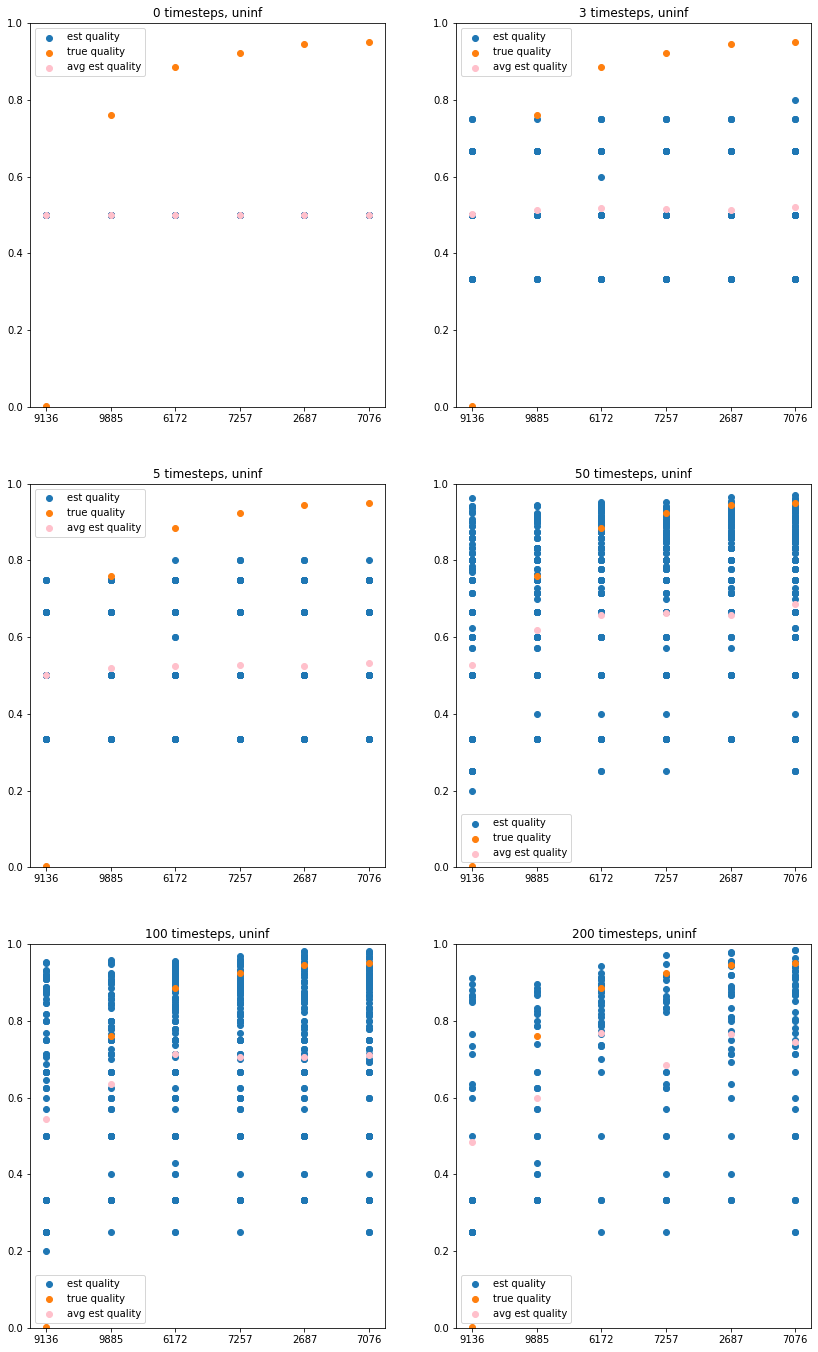

In [518]:
f, axes = plt.subplots(3,2)
f.set_size_inches(14,24)
ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
for i in range(len(ax_path)):
    t = times_of_interest[i]
    plot_quality_scatter(uninf_dict, true_quality, uninf_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, uninf')
plt.show()

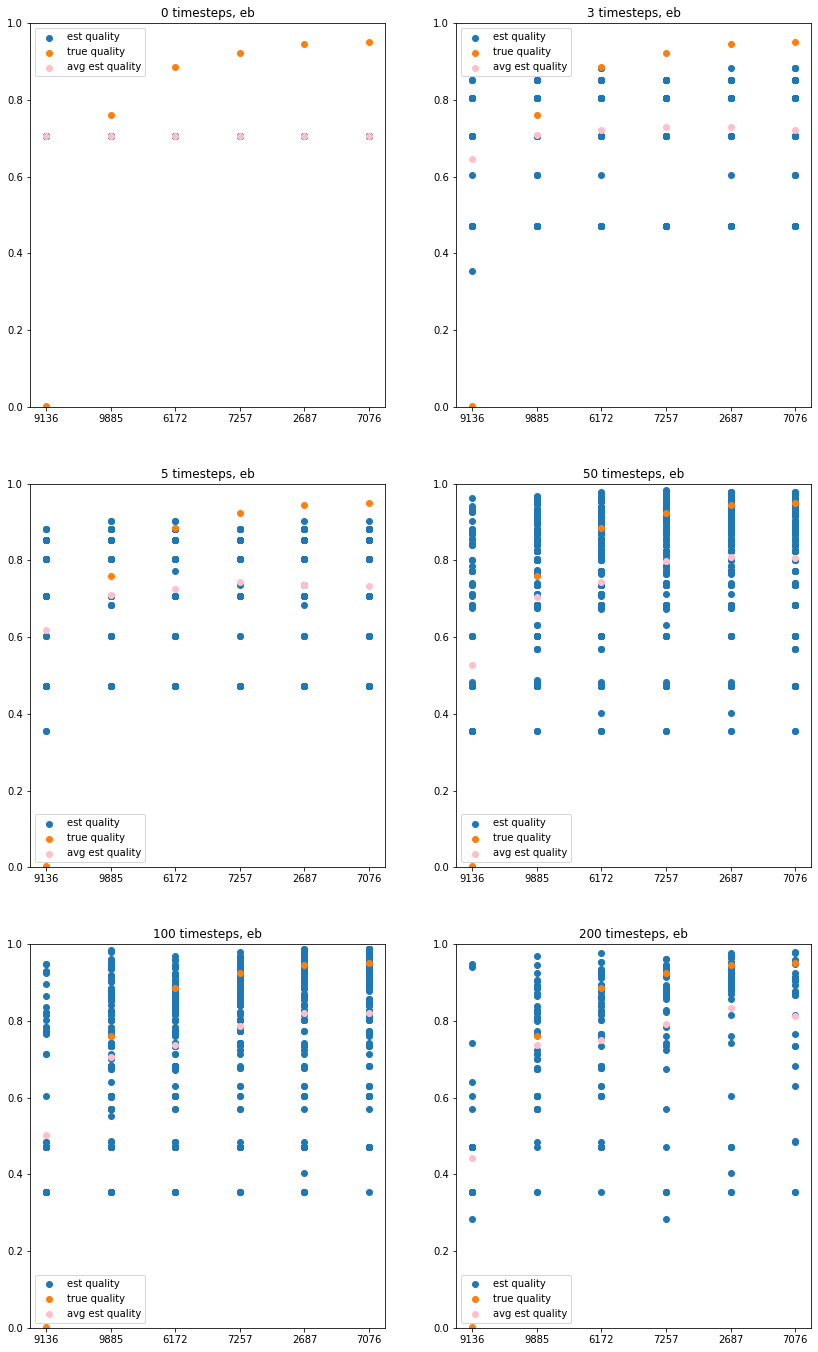

In [519]:
f, axes = plt.subplots(3,2)
f.set_size_inches(14,24)
ax_path = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1]]
for i in range(len(ax_path)):
    t = times_of_interest[i]
    plot_quality_scatter(eb_dict, true_quality, eb_conf_intervals, videos_of_interest, t, ax=ax_path[i],title=f'{t} timesteps, eb')
plt.show()

### 5.1 Plot the histogram of plays for each product

In [520]:
# uninf_data_counts_y = [[(np.sum(arr[-1,:])-2) for arr in uninformed_data[key]] for key in videos_of_interest]
# eb_data_counts_y = [[(np.sum(arr[-1,:])-(prior_a+prior_b)) for arr in eb_data[key]] for key in videos_of_interest]
# uninf_data_counts_x = [[arr.shape[0] for arr in uninformed_data[key]] for key in videos_of_interest]
# eb_data_counts_x = [[arr.shape[0] for arr in eb_data[key]] for key in videos_of_interest]
# uninf_data_counts = [[(np.sum(arr[-1,:])-2)/arr.shape[0] for arr in uninformed_data[key]] for key in videos_of_interest]
# eb_data_counts = [[(np.sum(arr[-1,:])-(prior_a+prior_b))/arr.shape[0] for arr in eb_data[key]] for key in videos_of_interest]

In [521]:
# f, axes = plt.subplots(6,2)
# f.set_size_inches(12,24)
# for i in range(len(videos_of_interest)):
#     plt.sca(axes[i,0])
#     plt.ylim(0, 10)
#     plt.xlim(0,1)
#     plt.title(f"{videos_of_interest[i]} + uninf")
#     sns.kdeplot(uninf_data_counts[i])
#     plt.sca(axes[i,1])
#     plt.ylim(0, 10)
#     plt.xlim(0,1)
#     plt.title(f"{videos_of_interest[i]} + eb")
#     sns.kdeplot(eb_data_counts[i])
    
# plt.show()

In [522]:
# helper function to pad a one-dimensional array with zeros

def pad_with_zeros(a, target_length):
    if a.shape[0] > target_length:
        raise Exception('array shape exceeds target length')
    else:
        diff = target_length - a.shape[0]
        return np.append(a, np.zeros(target_length - a.shape[0]))

In [523]:
max_uninf_size = max([max([uninformed_data[key][i].shape[0] for i in range(len(uninformed_data[key]))]) for key in uninformed_data])
avg_uninf_plays, freq_uninf_plays = np.zeros(max_uninf_size), np.zeros(max_uninf_size)

for key in uninformed_data:
    for arr in uninformed_data[key]:
        plays = np.sum(arr, axis=1)-2
        avg_uninf_plays += pad_with_zeros(plays, max_uninf_size)
        freq_uninf_plays += pad_with_zeros(np.ones(plays.shape[0]), max_uninf_size)
        
avg_uninf_plays /= freq_uninf_plays

In [524]:
uninf_plays_per_timestep = dict()
uninf_freq_per_timestep = dict()
for key in videos_of_interest:
    uninf_plays_per_timestep[key] = np.zeros(max([uninformed_data[key][i].shape[0] for i in range(len(uninformed_data[key]))]))
    freq_count = np.zeros(max([uninformed_data[key][i].shape[0] for i in range(len(uninformed_data[key]))]))
    for arr in uninformed_data[key]:
        plays = np.sum(arr, axis=1)-2
        uninf_plays_per_timestep[key] += pad_with_zeros(plays, uninf_plays_per_timestep[key].shape[0])
        freq_count += pad_with_zeros(np.ones(plays.shape[0]), uninf_plays_per_timestep[key].shape[0])
    uninf_freq_per_timestep[key] = copy.deepcopy(freq_count)
    
    uninf_plays_per_timestep[key] /= freq_count

In [525]:
max_eb_size = max([max([eb_data[key][i].shape[0] for i in range(len(eb_data[key]))]) for key in eb_data])
avg_eb_plays, freq_eb_plays = np.zeros(max_eb_size), np.zeros(max_eb_size)

for key in eb_data:
    for arr in eb_data[key]:
        plays = np.sum(arr, axis=1)-(prior_a + prior_b)
        avg_eb_plays += pad_with_zeros(plays, max_eb_size)
        freq_eb_plays += pad_with_zeros(np.ones(plays.shape[0]), max_eb_size)
        
avg_eb_plays /= freq_eb_plays

In [526]:
eb_plays_per_timestep = dict()
eb_freq_per_timestep = dict()
for key in videos_of_interest:
    eb_plays_per_timestep[key] = np.zeros(max([eb_data[key][i].shape[0] for i in range(len(eb_data[key]))]))
    freq_count = np.zeros(max([eb_data[key][i].shape[0] for i in range(len(eb_data[key]))]))
    for arr in eb_data[key]:
        plays = np.sum(arr, axis=1)-(prior_a + prior_b)
        eb_plays_per_timestep[key] += pad_with_zeros(plays, eb_plays_per_timestep[key].shape[0])
        freq_count += pad_with_zeros(np.ones(plays.shape[0]), eb_plays_per_timestep[key].shape[0])
    eb_freq_per_timestep[key] = copy.deepcopy(freq_count)
    
    eb_plays_per_timestep[key] /= freq_count

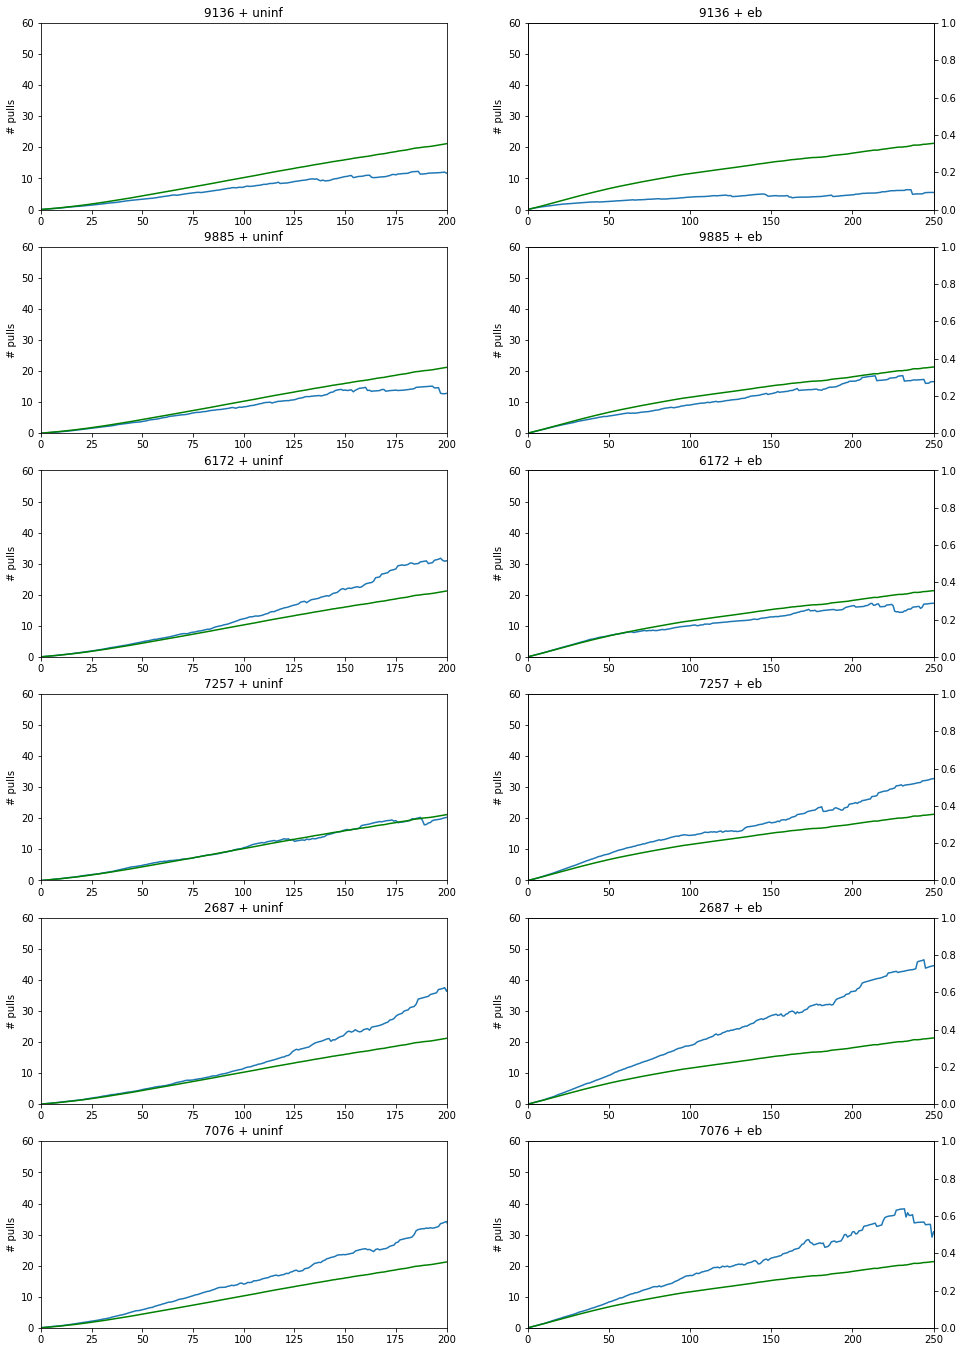

In [527]:
f, axes = plt.subplots(6,2)
f.set_size_inches(16,24)
for i in range(len(videos_of_interest)):
    plt.sca(axes[i,0])
#     twin = axes[i,0].twinx()
    axes[i,0].set_ylim(0, 60)
    axes[i,0].set_ylabel('# pulls')
#     twin.set_ylabel('# occurrences')
#     twin.set_ylim(0,500)
    plt.xlim(0,200)
    plt.title(f"{videos_of_interest[i]} + uninf")
    axes[i,0].plot(uninf_plays_per_timestep[videos_of_interest[i]],label='number of pulls')
    axes[i,0].plot(avg_uninf_plays, color='green')
#     twin.plot(uninf_freq_per_timestep[videos_of_interest[i]],color='red',alpha=0.5,label='frequency')
    
    plt.sca(axes[i,1])
    twin = axes[i,1].twinx()
    axes[i,1].set_ylim(0, 60)
    axes[i,1].set_ylabel('# pulls')
#     twin.set_ylim(0,500)
#     twin.set_ylabel('# occurrences')
    plt.xlim(0,250)
    plt.title(f"{videos_of_interest[i]} + eb")
    axes[i,1].plot(eb_plays_per_timestep[videos_of_interest[i]], label='number of pulls')
    axes[i,1].plot(avg_eb_plays, color='green')
#     twin.plot(eb_freq_per_timestep[videos_of_interest[i]],color='red',alpha=0.5,label='number of pulls')

## 6 Plot what happens to an out-of-sample good when it enters this marketplace

### 6.1 picking out-of-sample goods

In [528]:
sorted_test_videos = test_videos.sort_values()
print(sorted_test_videos)
sorted_test_videos = np.abs(sorted_test_videos - sorted_test_videos[7257])
print(sorted_test_videos.sort_values())

video_id
10094    0.000709
1170     0.001417
3978     0.002126
7196     0.002126
9136     0.002835
           ...   
9815     0.963855
4040     0.970234
4123     0.971651
5464     0.974468
1305     0.980142
Name: liked, Length: 1331, dtype: float64
video_id
7034     0.000000
674      0.000000
1373     0.000000
7257     0.000000
2666     0.000000
           ...   
9136     0.920624
7196     0.921332
3978     0.921332
1170     0.922041
10094    0.922750
Name: liked, Length: 1331, dtype: float64


In [529]:
out_of_sample_vids = [10094, 7034, 1305] # worst, decent, and best from out-of-sample
any([vid in sampled_videos for vid in out_of_sample_vids])

False

In [530]:
aug_df = dict()
for k in out_of_sample_vids:
    aug_df[k] = kuairec_test[(kuairec_test['video_id'].isin(sampled_videos))|(kuairec_test['video_id']==k)]

In [531]:
second_timesteps = 50 # ideally keep this low so the out-of-sample simulation remains relatively accurate

In [532]:
np.array([uninformed_priors[-1]])

array([[1., 1.]])

In [533]:
def simulate_out_of_sample(chosen_df,
                           snapshots,
                           new_vid,
                           priors,
                           sampling_action,
                           timesteps,
                           num_sims,
                           num_users=1):
    trajectories = []
    for sim in range(num_sims):
        snapshot = copy.deepcopy(snapshots[int(np.random.choice([key for key in snapshots]))])
        curr_vids = snapshot[0] + [new_vid]
        product_data = dict(zip(curr_vids, [[] for _ in range(len(curr_vids))]))
        priors_dict = dict(zip(curr_vids, [priors.copy()[i,:] for i in range(priors.shape[0])]))
        
        
        helper = ProductHelper(product_data, curr_vids, list(curr_vids), priors_dict)
        helper.market = snapshot[1]
        helper.market.append(np.array([copy.deepcopy(priors[-1])]))
        if sim == 0:
            print(len(helper.market))
            print(helper.mkt_ids)
        for t in range(timesteps):
            latest_sims = np.array([item[-1] for item in helper.market])
            successes, failures = latest_sims[:,0], latest_sims[:,1]
            actions = range(len(curr_vids))
            for m in range(num_users):
                a = sampling_action(actions, successes, failures)
                like = sample_chosen_df(curr_vids, chosen_df, a)

                # update prior
                helper.pull_arm_update_market(a, like)
            
        trajectories.append(helper.market[-1])
    
    return trajectories

In [534]:
results_dict = dict()
for vid in out_of_sample_vids:
    for prior_type in ['eb', 'uninf']:
        print(f"now processing {vid}, {prior_type}")
        if prior_type == 'eb':
            priors = eb_priors
            snapshots = eb_snapshots
        else:
            priors = uninformed_priors
            snapshots = uninf_snapshots
        
        results_dict[(vid, prior_type)] = simulate_out_of_sample(kuairec_test,
                                                                 snapshots, 
                                                                 vid,
                                                                 priors,
                                                                 ts_action,
                                                                 second_timesteps,
                                                                 num_sims=100)


now processing 10094, eb
11
[2678, 929, 1061, 8588, 9997, 7109, 9872, 10506, 147, 5645, 10094]
now processing 10094, uninf
11
[7788, 350, 9136, 4664, 10279, 3935, 8572, 1178, 3917, 147, 10094]
now processing 7034, eb
11
[7264, 10330, 614, 5412, 4078, 2571, 9595, 2277, 1373, 1926, 7034]
now processing 7034, uninf
11
[627, 5513, 2444, 8572, 2311, 6898, 2542, 10279, 9102, 1178, 7034]
now processing 1305, eb
11
[8543, 4664, 5612, 1061, 3917, 2542, 7709, 350, 640, 883, 1305]
now processing 1305, uninf
11
[2444, 3033, 8543, 4744, 6251, 3019, 3946, 1997, 858, 1373, 1305]


In [535]:
traject_data = copy.deepcopy(dict(zip(results_dict.keys(),[np.array(results_dict[k]) for k in results_dict])))
for k in traject_data:
    traject_data[k] = traject_data[k][:,:,0]/(traject_data[k][:,:,0]+traject_data[k][:,:,1])
    df = pd.DataFrame(traject_data[k]).melt()
    df = df.rename(columns={'variable': 'timestep'})
    traject_data[k] = df

#### Plotting estimated quality over time for new products

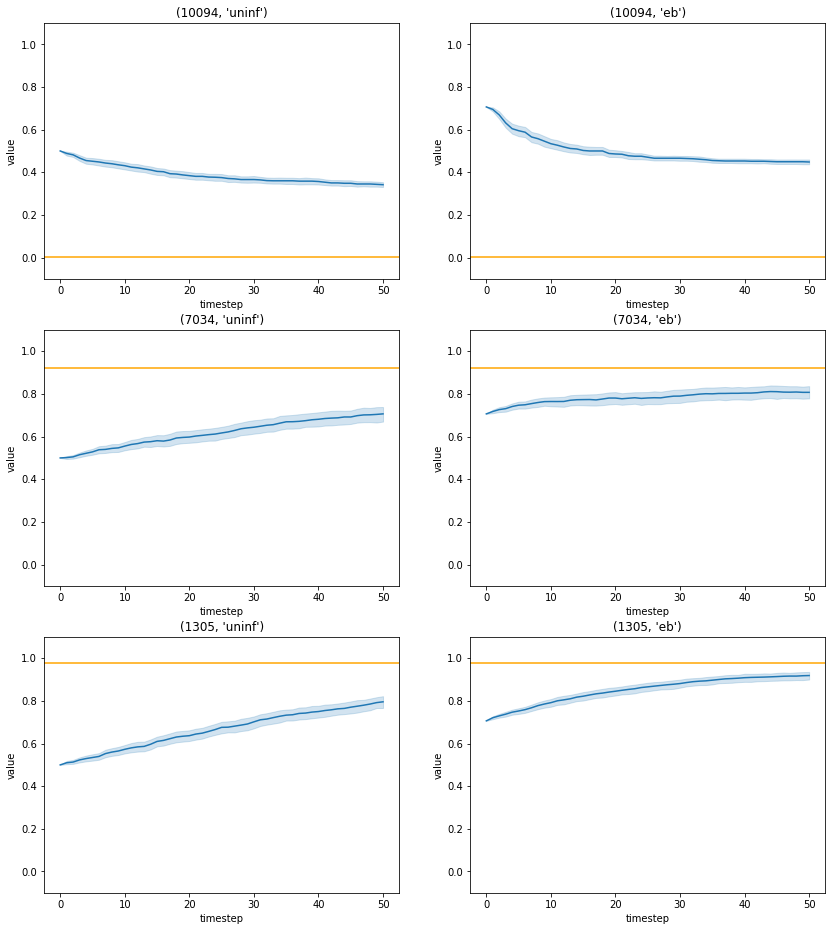

In [536]:
i=0
axis_tuples = [(0,1), (0,0), (1,1), (1,0), (2,1), (2,0)]
f, axes = plt.subplots(3,2)
f.set_size_inches(14,16)
for k in traject_data:
    plt.sca(axes[axis_tuples[i][0], axis_tuples[i][1]])
    plt.ylim(-0.1, 1.1)
#     for j in range(100):
#         plt.plot(results_dict[k][j][:,0]/(results_dict[k][j][:,0]+results_dict[k][j][:,1]),color='blue')
#     plt.axhline(test_videos[k[0]],color='orange')
#     plt.title(k)

    graph = sns.lineplot(traject_data[k],x='timestep',y='value')
    graph.set_title(k)
    graph.axhline(test_videos[k[0]],color='orange')
    i += 1

In [537]:
traject_data = copy.deepcopy(dict(zip(results_dict.keys(),[np.array(results_dict[k]) for k in results_dict])))
for k in traject_data:
    if k[1] == 'eb':
        traject_data[k] = (traject_data[k][:,:,0]+traject_data[k][:,:,1]) - (prior_a + prior_b)
    else:
        traject_data[k] = (traject_data[k][:,:,0]+traject_data[k][:,:,1]) - 2
    df = pd.DataFrame(traject_data[k]).melt()
    df = df.rename(columns={'variable': 'timestep'})
    traject_data[k] = df

#### Plotting number of plays for each product

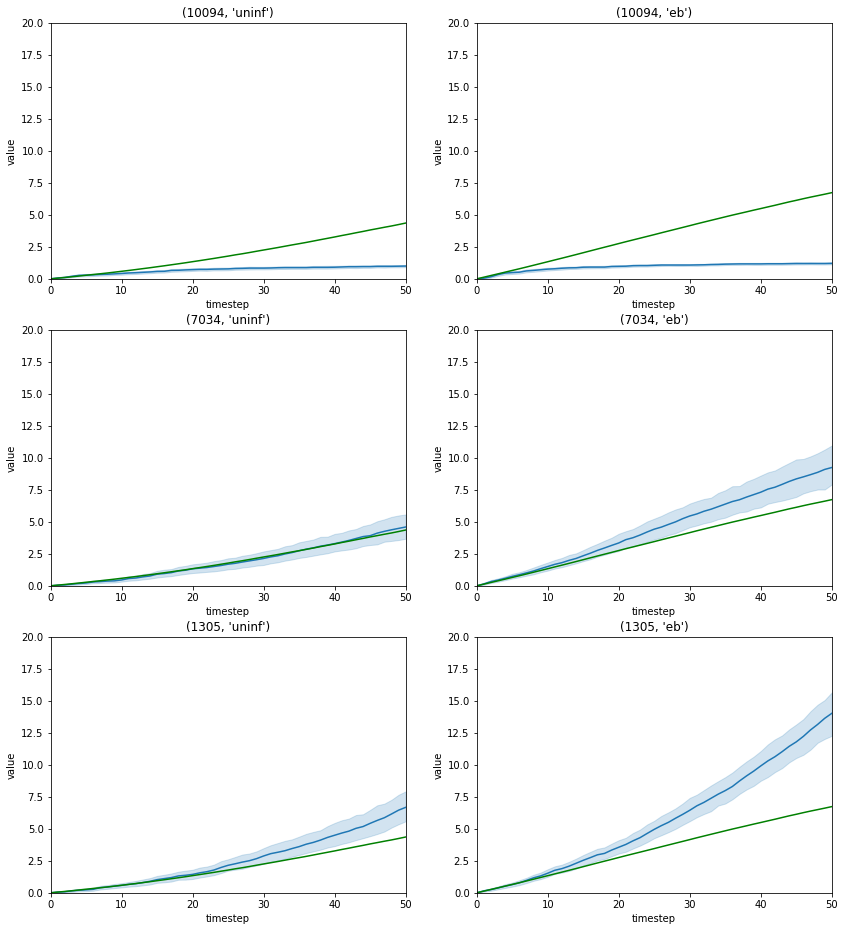

In [538]:
i=0
axis_tuples = [(0,1), (0,0), (1,1), (1,0), (2,1), (2,0)]
f, axes = plt.subplots(3,2)
f.set_size_inches(14,16)
for k in traject_data:
    plt.sca(axes[axis_tuples[i][0], axis_tuples[i][1]])
    plt.ylim(0,20)
    plt.xlim(0,50)
    graph = sns.lineplot(traject_data[k],x='timestep',y='value')
    graph.set_title(k)
    if k[1]=='uninf':
        plt.plot(avg_uninf_plays,color='green')
    else:
        plt.plot(avg_eb_plays,color='green')
    i += 1